In [1]:
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt

def generate_ar_code(id, size):
    # Define parameters for the AR tag
    acuro_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    tag_id = id  # ID of the AR tag to generate
    tag_size = size  # Size of the AR tag in pixels

    # Generate the AR tag
    tag_image = aruco.generateImageMarker(acuro_dict, tag_id, tag_size)

    # Display the generated AR tag
    plt.imshow(tag_image, cmap='gray')
    plt.axis('off')
    plt.show()

    # Optionally, save the generated AR tag to a file
    cv2.imwrite('ar_tag.png', tag_image)

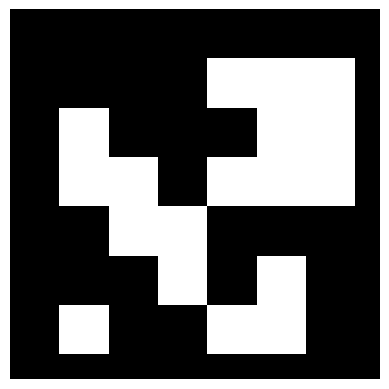

In [2]:
generate_ar_code(0, 15)

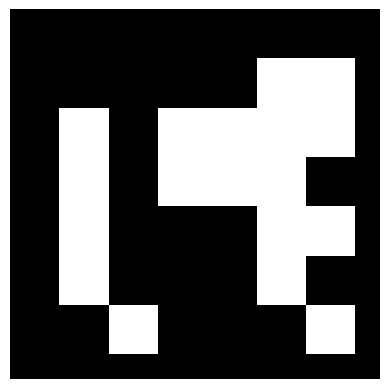

In [3]:
generate_ar_code(1, 15)

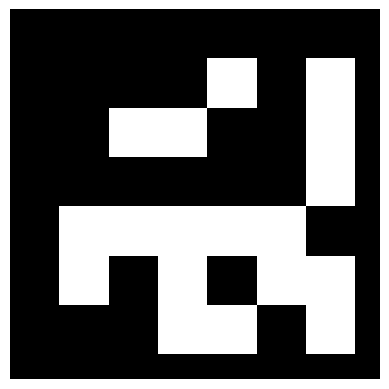

In [4]:
generate_ar_code(2, 15)

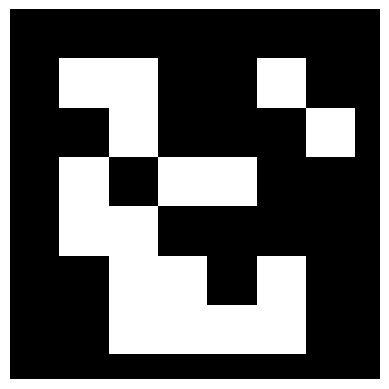

In [5]:
generate_ar_code(3, 15)

Load image and detect AR codes

# Data loading combined (restart kernel here)

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt

In [2]:
breedte_resultaat = 1480
hoogte_resultaat = 1000

# Transformeer de afbeelding zodat de positie van de gedetecteerde markers wordt toegewezen aan (10, 10) en (1480, 1000)
def transformeer_afbeelding(afbeeldingsmatrix, markerpunten):
    # Definieer de doelposities van de markers.
    doelposities = np.array([[0, 0], [0, hoogte_resultaat], [breedte_resultaat, 0], [breedte_resultaat, hoogte_resultaat]], dtype=np.float32)

    # Compute the perspective transformation matrix
    transformatiematrix = cv2.getPerspectiveTransform(markerpunten, doelposities)

    # Apply the perspective transformation to the image
    getransformeerde_afbeelding = cv2.warpPerspective(afbeeldingsmatrix, transformatiematrix, (breedte_resultaat, hoogte_resultaat))

    return getransformeerde_afbeelding

# Cut square images of size 240x240 with an offset of 20 pixels from the top and left edges of the transformed image
def knip_afbeeldingen_uit_matrix(afbeeldingsmatrix, formaat, offset, crop_marge=10):
    afbeeldingen = []
    for i in range(offset, afbeeldingsmatrix.shape[1] - offset, formaat):
        for j in range(offset, afbeeldingsmatrix.shape[0] - offset - 1, formaat):
            knip = afbeeldingsmatrix[j + crop_marge:j + formaat - crop_marge, i + crop_marge:i + formaat - crop_marge]
            # Turn the image into a binary image
            _, knip = cv2.threshold(knip, 127, 255, cv2.THRESH_BINARY)
            # Convert to 1d grayscale image
            knip = cv2.cvtColor(knip, cv2.COLOR_BGR2GRAY)
            afbeeldingen.append(knip)
    return afbeeldingen


def emoticons_inladen(bestandsnaam_afbeelding_raster, emotie):
    # Laadt de rastarafbeelding in.
    raster = Image.open(bestandsnaam_afbeelding_raster)
    # Zet de afbeelding om naar een numpy tensor.
    raster_array = np.array(raster)
    
    # Detecteer de markers in de afbeelding.
    acuro_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    markers, ids, rejectedImgPoints = aruco.detectMarkers(raster_array, acuro_dict)
    id_lijst = list(ids)
    
    # Check of allevier de markers zijn gevonden.
    if len(id_lijst) != 4:
        print("Niet alle markers zijn gevonden.")
        print("Probeer een nieuwe foto te maken van je raster waarop de markers duidelijk zichtbaar zijn en in focus zijn.")
        return [], []
    
    # Transformeer de afbeelding.
    markerpunten = np.array([markers[id_lijst.index(0)][0][2], markers[id_lijst.index(1)][0][1], markers[id_lijst.index(2)][0][3], markers[id_lijst.index(3)][0][0]], dtype=np.float32)
    getransformeerde_afbeelding = transformeer_afbeelding(raster_array, markerpunten)
    
    # Knip de afbeeldingen uit.
    afbeeldingen = knip_afbeeldingen_uit_matrix(getransformeerde_afbeelding, 240, 20)
    # Maak labels voor de afbeeldingen.
    labels = np.array([emotie] * len(afbeeldingen))
    
    return afbeeldingen, labels

def toon_afbeeldingen(afbeeldingen, labels):
    cols = 6
    fig, axs = plt.subplots(len(afbeeldingen)//cols, cols, figsize=(20, 20))
    for i, ax_row in enumerate(axs):
        for j, ax in enumerate(ax_row):
            if i*cols + j >= len(afbeeldingen):
                break
            ax.imshow(afbeeldingen[i*cols + j], cmap='gray')
            ax.axis('off')
            ax.set_title(labels[i*cols + j])
    plt.show()

In [3]:
# Iterate all images in folder assign the folder name as label
import os
from PIL import Image
import numpy as np

    
def laadt_bestanden_in_map_met_label(path, label):
    afbeeldingen = []
    labels = []
    for bestandsnaam in os.listdir(path):
        afbeeldingen_emoticon, labels_emoticon = emoticons_inladen(os.path.join(path, bestandsnaam), label)
        afbeeldingen.extend(afbeeldingen_emoticon)
        labels.extend(labels_emoticon)
    return afbeeldingen, labels

emoticons_blij, labels_blij = laadt_bestanden_in_map_met_label("images/blij", "blij")
emoticons_verbaasd, labels_verbaasd = laadt_bestanden_in_map_met_label("images/verbaasd", "verbaasd")


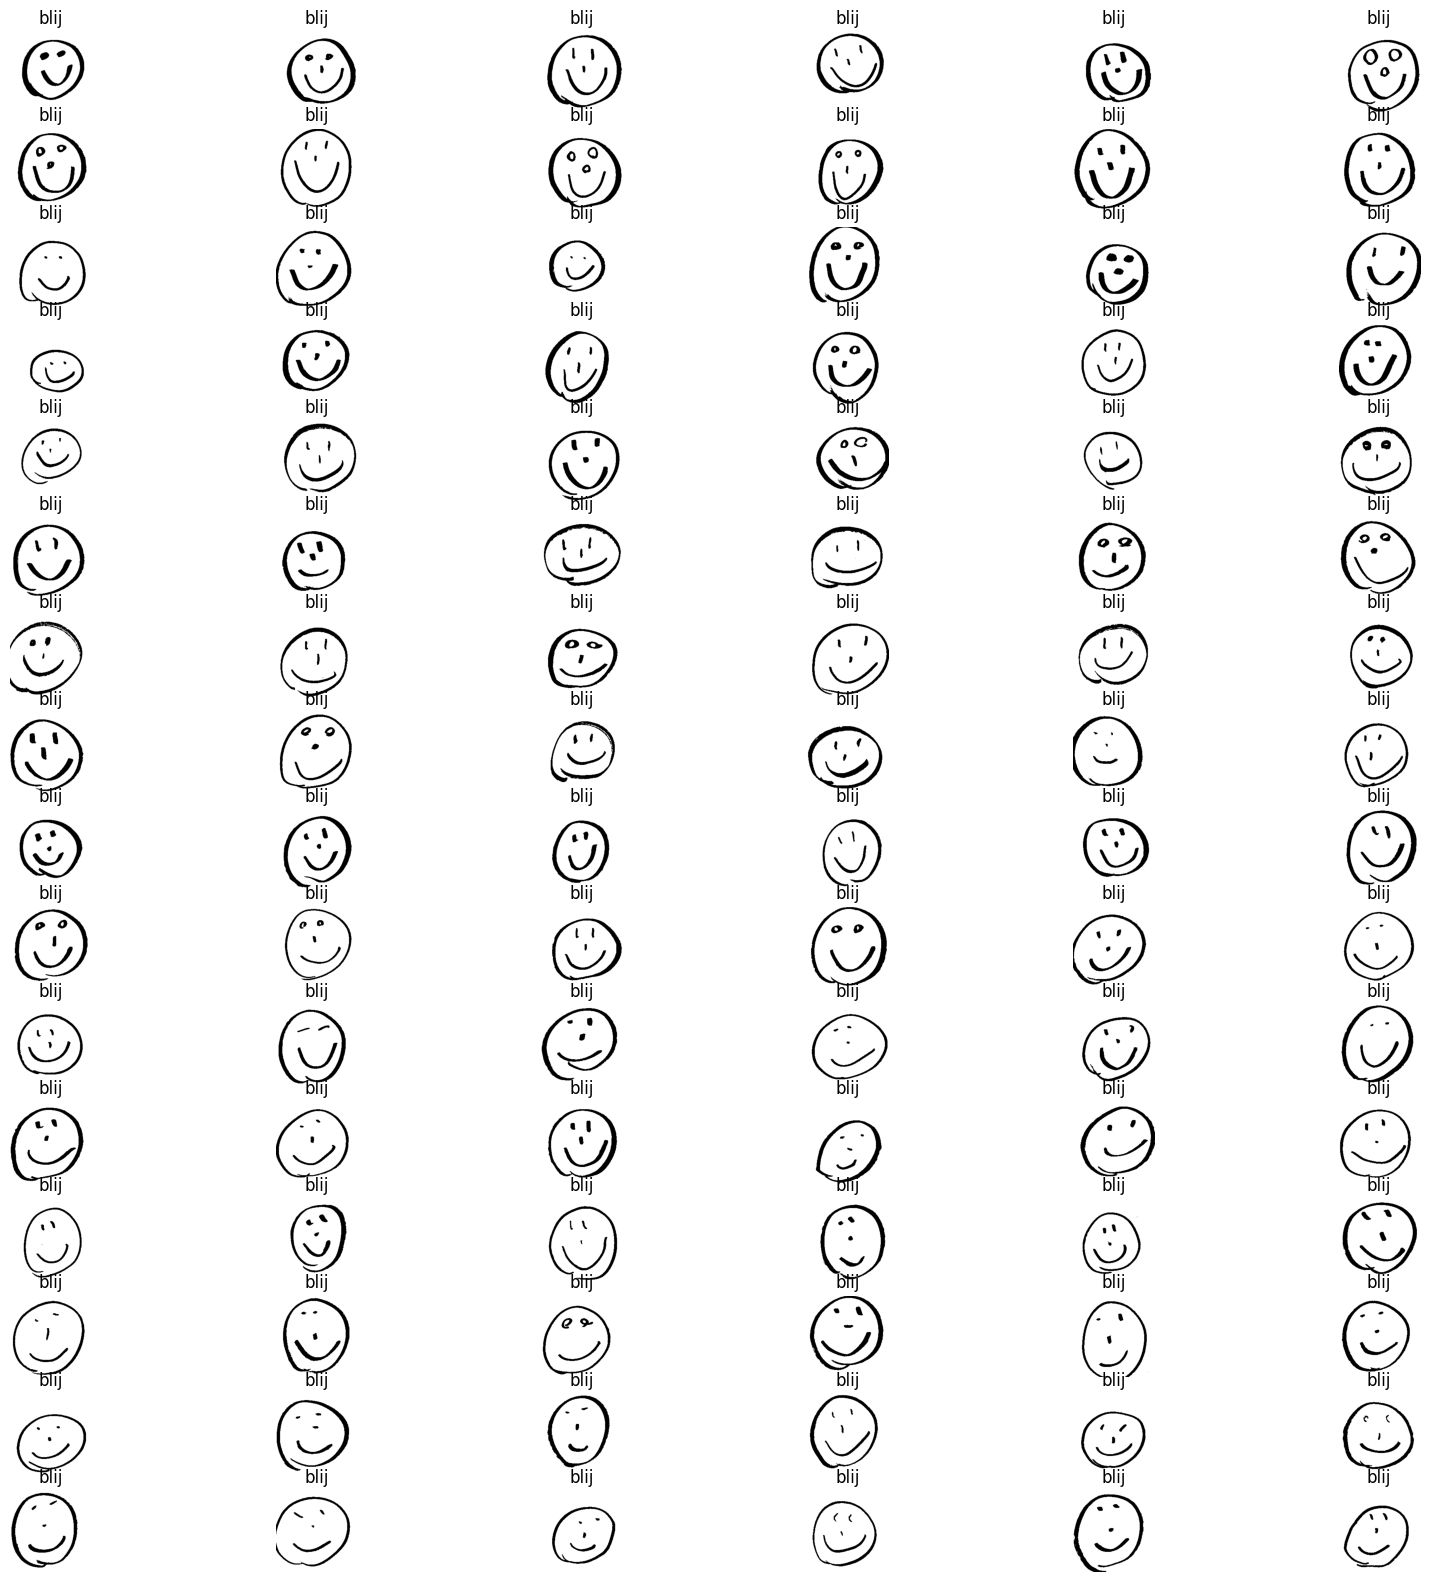

In [5]:
toon_afbeeldingen(emoticons_blij, labels_blij)

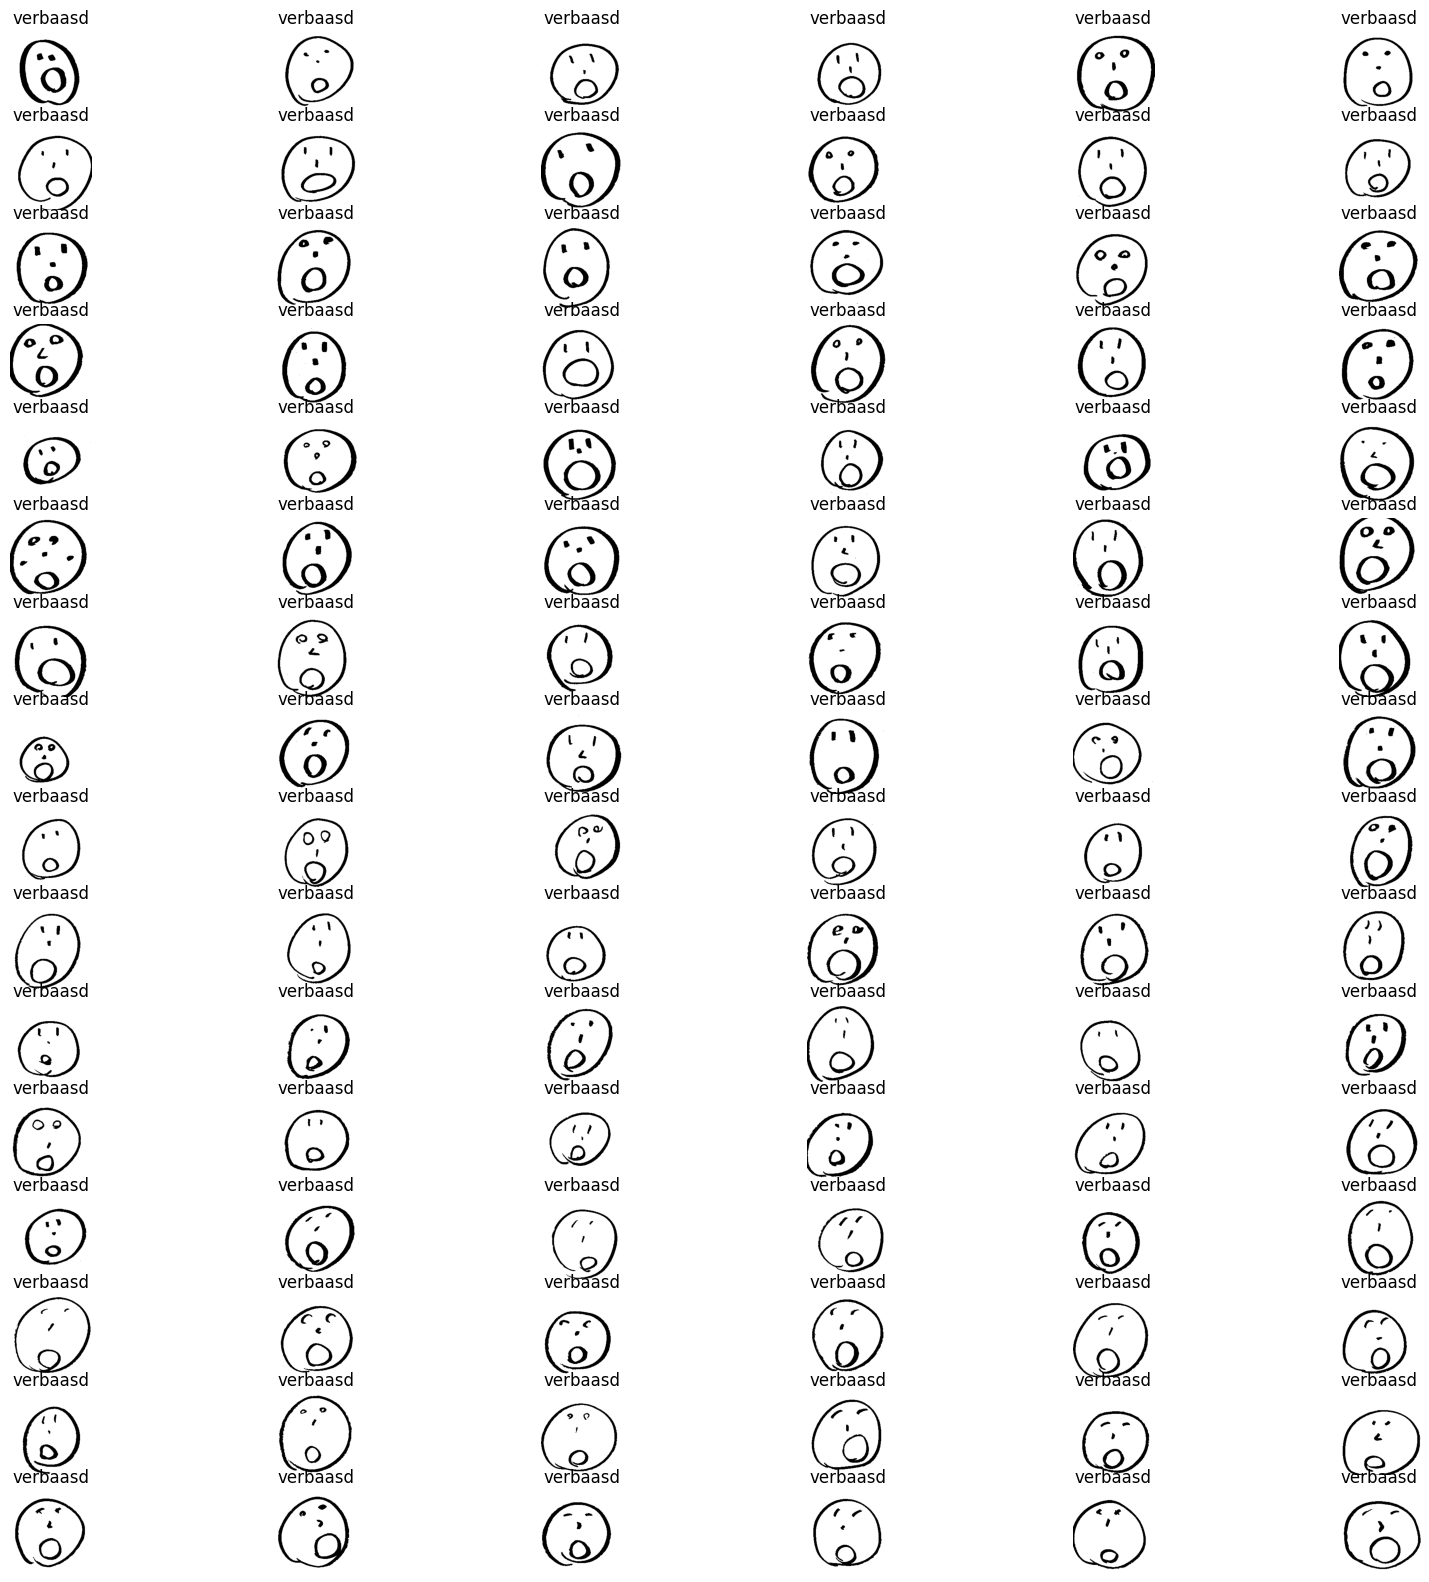

In [6]:
toon_afbeeldingen(emoticons_verbaasd, labels_verbaasd)

In [7]:
afbeeldingen = np.vstack([np.array(emoticons_blij), np.array(emoticons_verbaasd)])
labels = np.concatenate([np.array(labels_blij), np.array(labels_verbaasd)])


In [8]:
afbeeldingen.shape, labels.shape

((192, 220, 220), (192,))

In [9]:
# apply a 2d convolution to all numpy arrays in the dataset with a 40x40 kernel and a stride of 20
def apply_convolution(dataset, kernel_size=10, stride=10):
    # Define the kernel
    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2

    # Apply the convolution to all images in the dataset
    convolved_images = []
    for image in dataset:
        convolved_image = cv2.filter2D(image, -1, kernel)[::stride, ::stride]
        convolved_images.append(convolved_image)

    return np.array(convolved_images)




In [10]:
uitgemiddelde_afbeeldingen = apply_convolution(afbeeldingen)


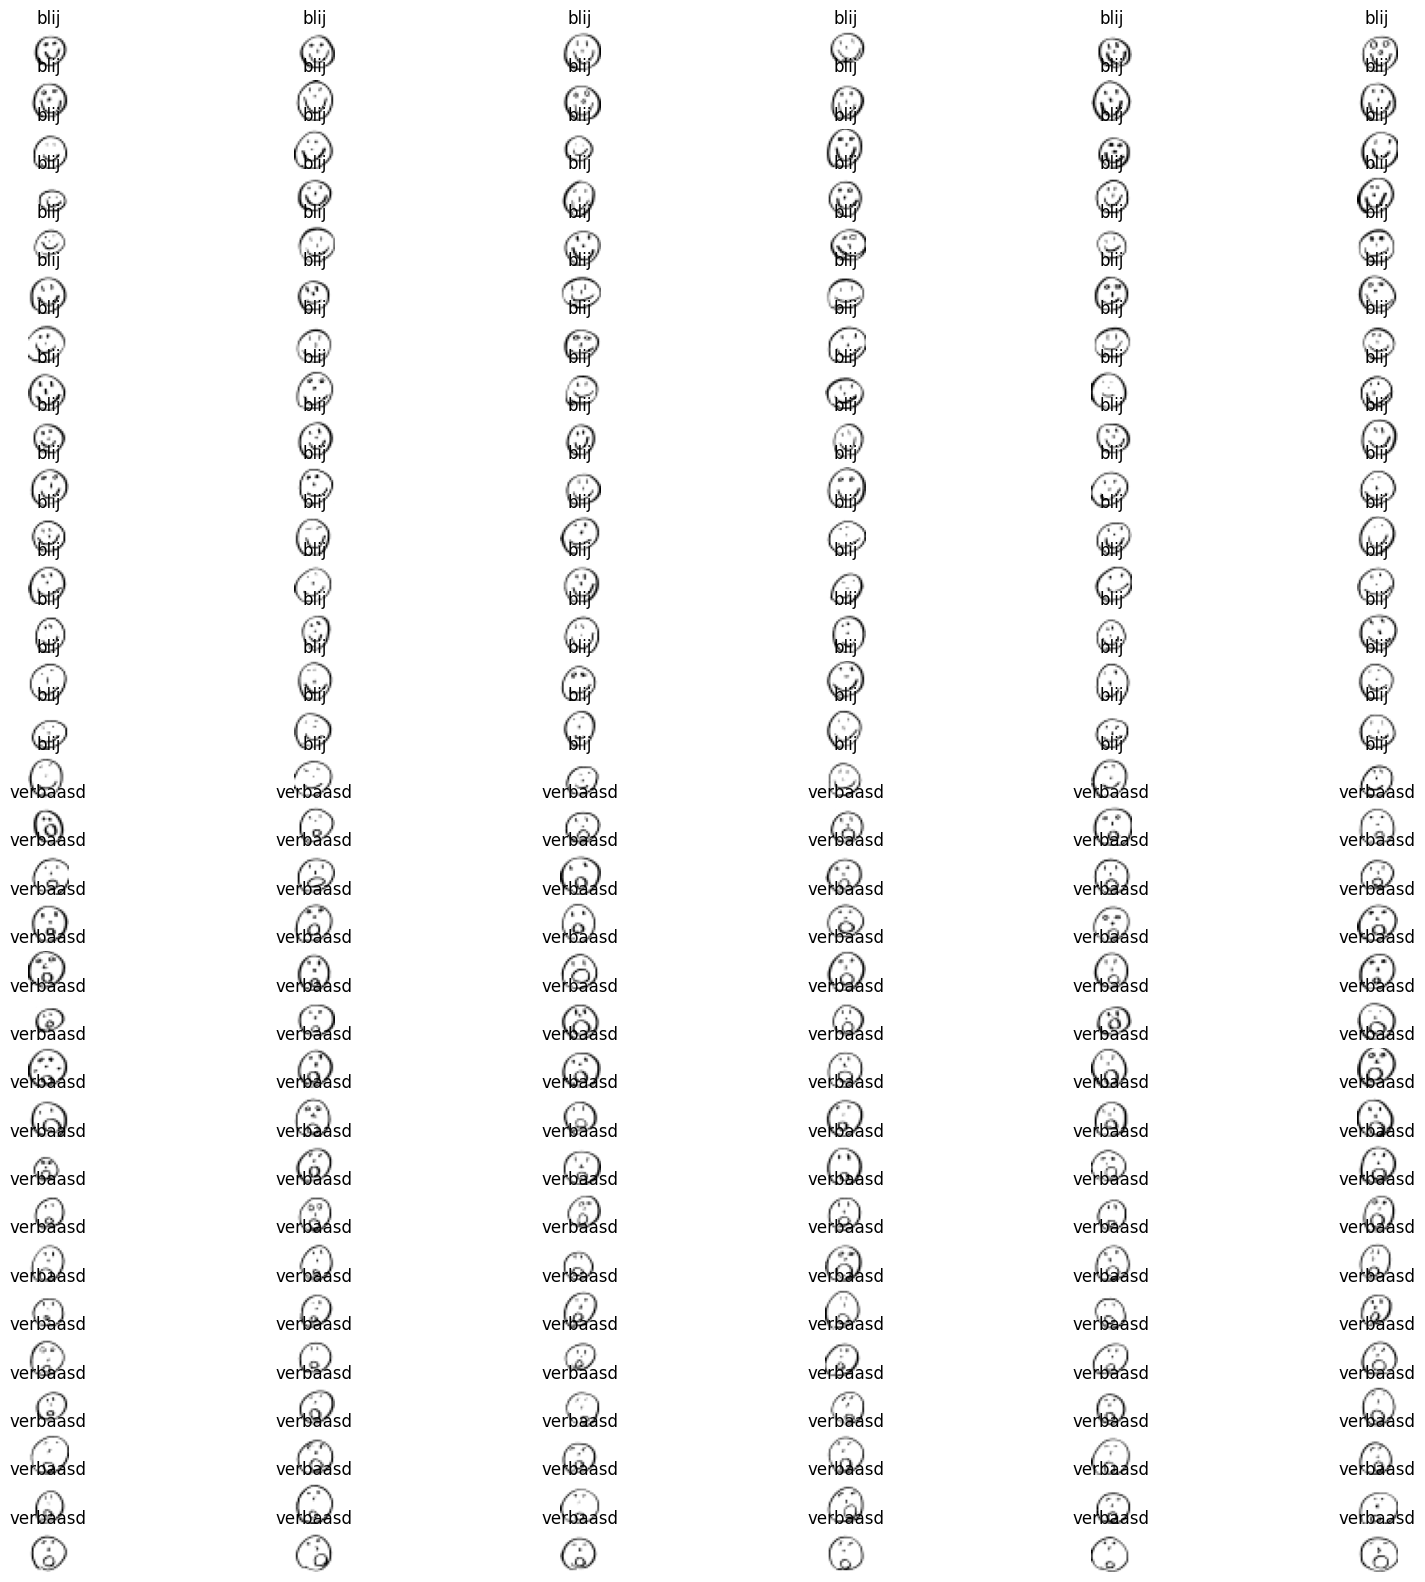

In [11]:
toon_afbeeldingen(uitgemiddelde_afbeeldingen, labels)

In [12]:
# flatten a list of 2d numpy arrays
def flatten_dataset(dataset):
    return np.array([image.flatten() for image in dataset])

# flatten the dataset
afbeeldingen_flat = flatten_dataset(uitgemiddelde_afbeeldingen)


In [13]:
# Cluster the images using k-means
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 2

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(afbeeldingen_flat)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Display the cluster labels
print(cluster_labels)
labels_numeric = np.array([0 if label == "blij" else 1 for label in labels])
print(labels_numeric)

# Calculate cluster purity
def calculate_purity(cluster_labels, true_labels, n_clusters):
    # Initialize the confusion matrix
    confusion_matrix = np.zeros((n_clusters, n_clusters))

    # Fill the confusion matrix
    for i in range(len(cluster_labels)):
        confusion_matrix[cluster_labels[i], true_labels[i]] += 1

    # Calculate the purity
    purity = np.sum(np.max(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

    return purity, confusion_matrix

purity, confusion_matrix = calculate_purity(cluster_labels, labels_numeric, n_clusters)

print("Purity:", purity)
print("Confusion matrix:")
print(confusion_matrix)




[1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0
 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1
 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0
 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 0 0 1 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Purity: 0.7083333333333334
Confusion matrix:
[[26. 30.]
 [70. 66.]]


In [14]:
from sklearn.decomposition import PCA

# apply pca to the flattened dataset
def apply_pca(dataset, n_components=2):
    # Perform PCA on the flattened dataset
    pca = PCA(n_components=n_components)
    pca.fit(dataset)
    transformed_dataset = pca.transform(dataset)

    return transformed_dataset

afbeeldingen_pca = apply_pca(afbeeldingen_flat)

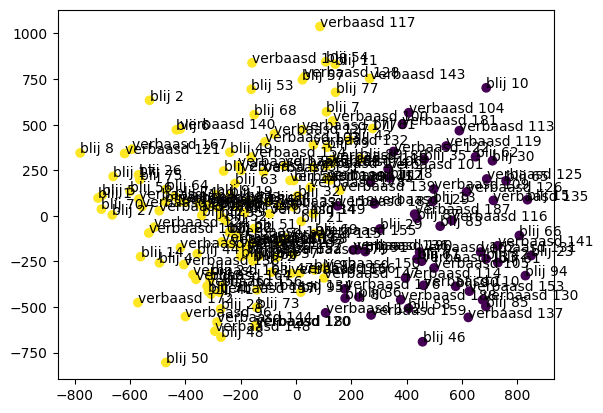

In [15]:
# Geef de vingerafdrukken weer in een spreidingsdiagram.
plt.scatter(afbeeldingen_pca[:, 0], afbeeldingen_pca[:, 1], c=cluster_labels)
for i, label in enumerate(labels):
    plt.text(afbeeldingen_pca[i, 0], afbeeldingen_pca[i, 1], label + " " + str(i))
plt.show()

In [16]:
# Inspect the filters the cnn has learned
def inspect_filters(model, layer=0):
    # Get the weights of the first layer
    weights = model.layers[layer].get_weights()[0]

    # Display the filters
    cols = 4
    rows = 2
    fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
        if i >= weights.shape[3]:
            break
        ax.imshow(weights[:, :, 0, i], cmap='gray')
        ax.axis('off')
    plt.show()

[1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 1
 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0
 0 1 0 1 1]
[0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0
 1 1]
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5055 - loss: 6.5625
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4590 - loss: 4.7009
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5380 - loss: 3.4896
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5493 - loss: 2.5620
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5989 - loss: 1.8800
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6801 - loss: 1.7321
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6141 - loss: 1.4011
Epoch 8/100
5/5 ━━━

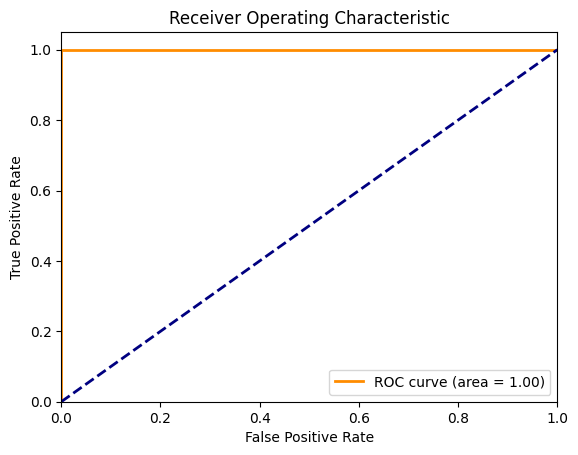

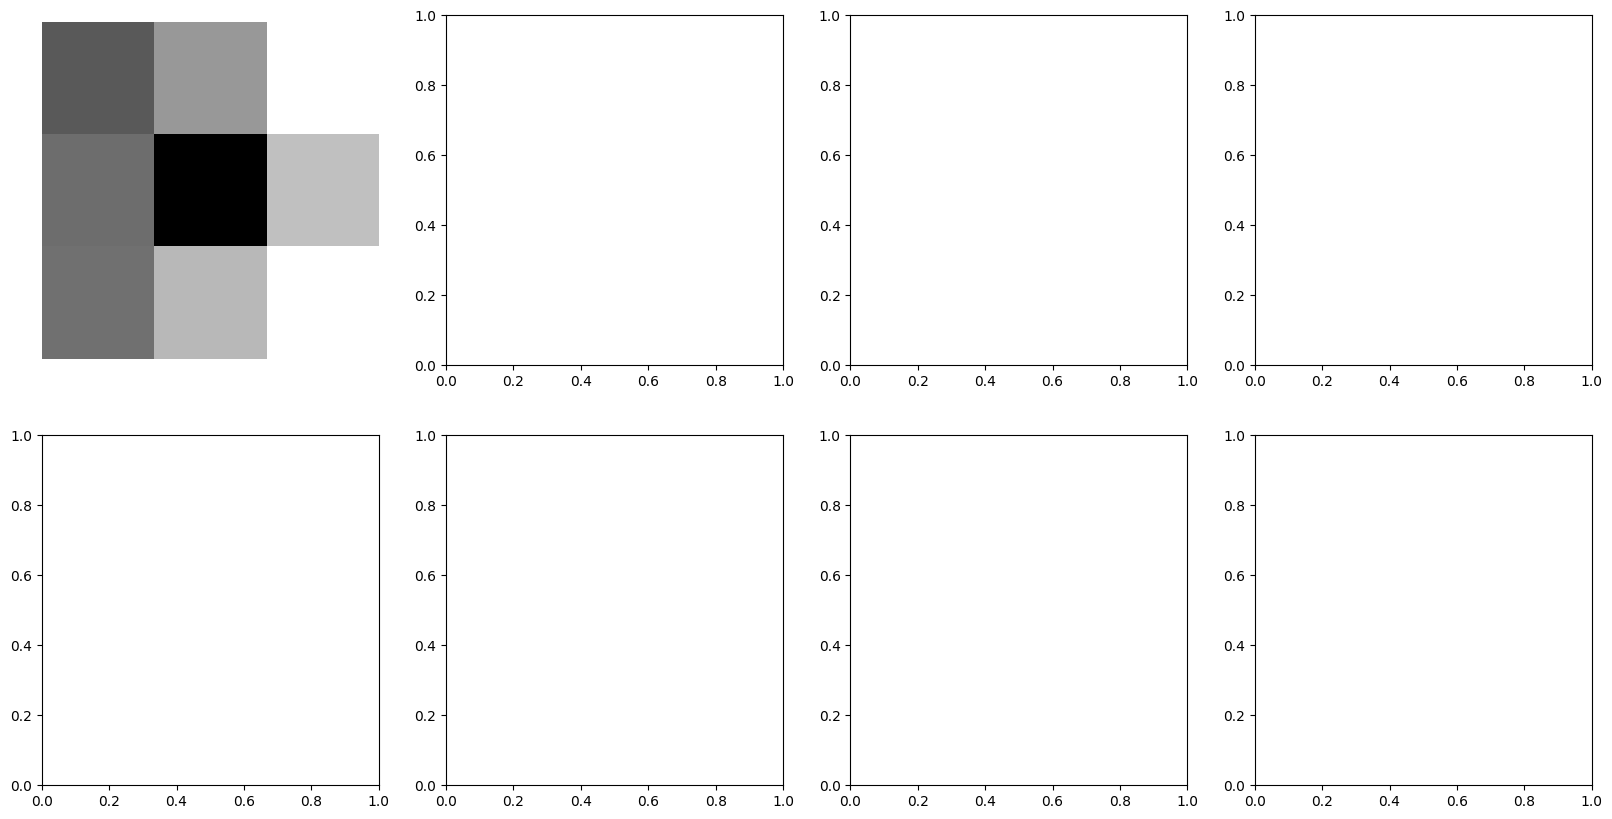

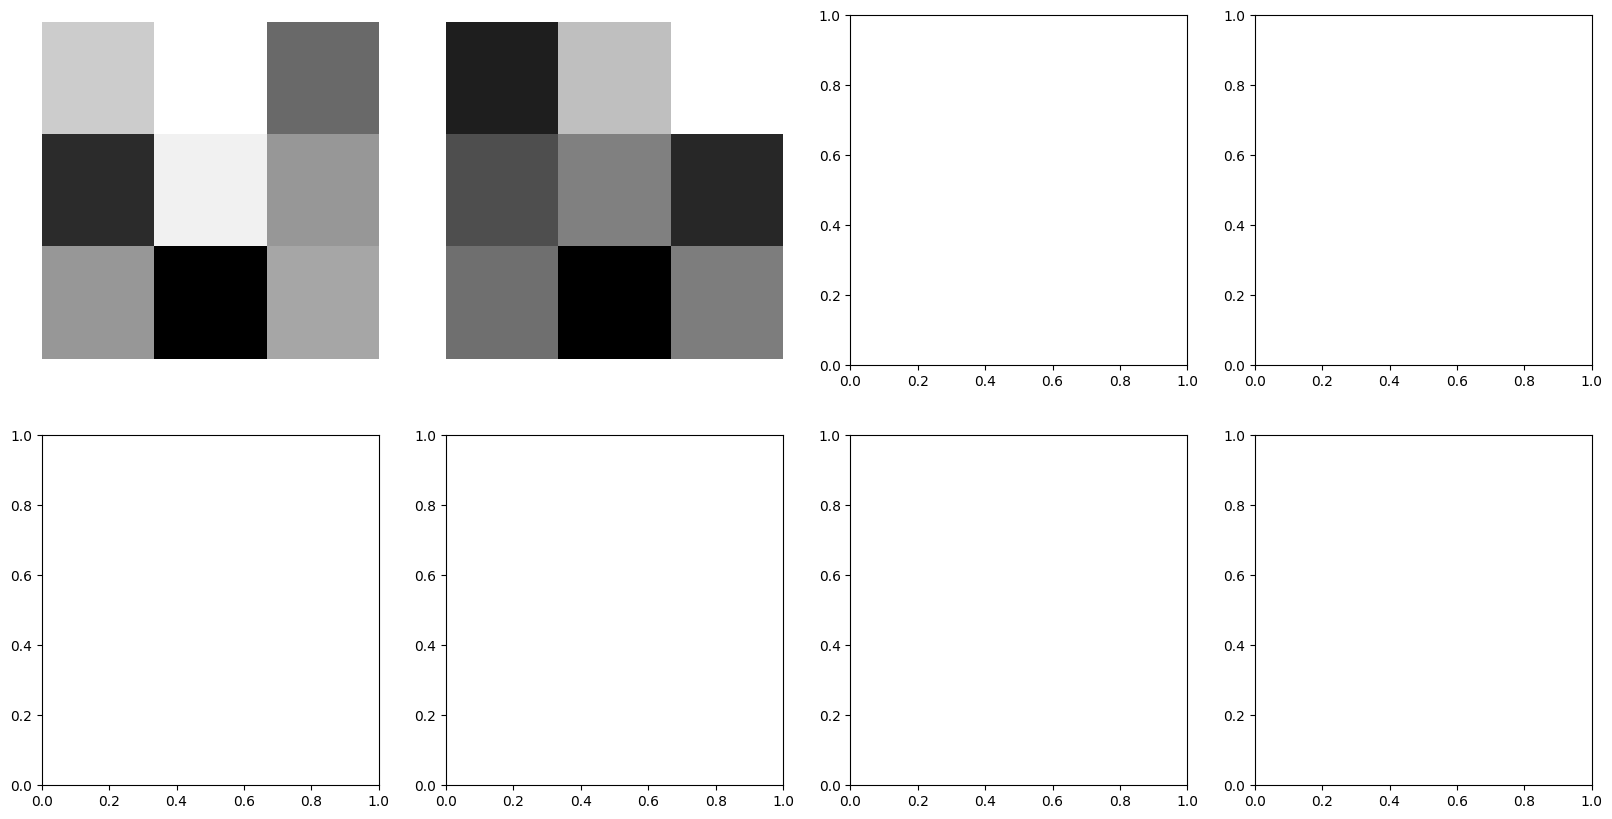

In [44]:
# Create a simple cnn model using keras and tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model2():
    # Define the model
    model = Sequential()
    model.add(Conv2D(8, (10, 10), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(8, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def create_cnn_model2():
    # Define the model
    model = Sequential()
    
    model.add(Conv2D(4, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def create_cnn_model():
    # Define the model
    model = Sequential()
    
    model.add(Conv2D(1, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(2, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(4, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Reshape the images to 3D tensors
afbeeldingen_3d = np.expand_dims(afbeeldingen, axis=-1)

# Split the dataset into a training and test set
from sklearn.model_selection import train_test_split

afbeeldingen_train, afbeeldingen_test, labels_train, labels_test = train_test_split(afbeeldingen_3d, labels_numeric, test_size=0.2)

# Augment training data with small random rotations and translations
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagenerator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
datagenerator.fit(afbeeldingen_train)



print(labels_train)
print(labels_test)

# Create the CNN model
model = create_cnn_model()

# Train the model
model.fit(afbeeldingen_train, labels_train, epochs=100)

# Evaluate the model
loss, accuracy = model.evaluate(afbeeldingen_test, labels_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Predict the labels of the images
predictions = model.predict(afbeeldingen_test)

# Display the predicted labels
predicted_labels = ["blij" if prediction < 0.5 else "verbaasd" for prediction in predictions]
print(predicted_labels)

# Calculate the confusion matrix
confusion_matrix = np.zeros((2, 2))
for i in range(len(labels_test)):
    confusion_matrix[labels_test[i], 0 if predictions[i] < 0.5 else 1] += 1
    
print("Confusion matrix:")
print(confusion_matrix)

# Calculate the accuracy
accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
print("Accuracy:", accuracy)

# Calculate the precision and recall
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

print("Precision:", precision)
print("Recall:", recall)

# Calculate the F1 score
f1_score = 2 * precision * recall / (precision + recall)
print("F1 score:", f1_score)

# Calculate the ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(labels_test, predictions)
roc_auc = auc(fpr, tpr)

# Display the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

inspect_filters(model)
inspect_filters(model, layer=3)


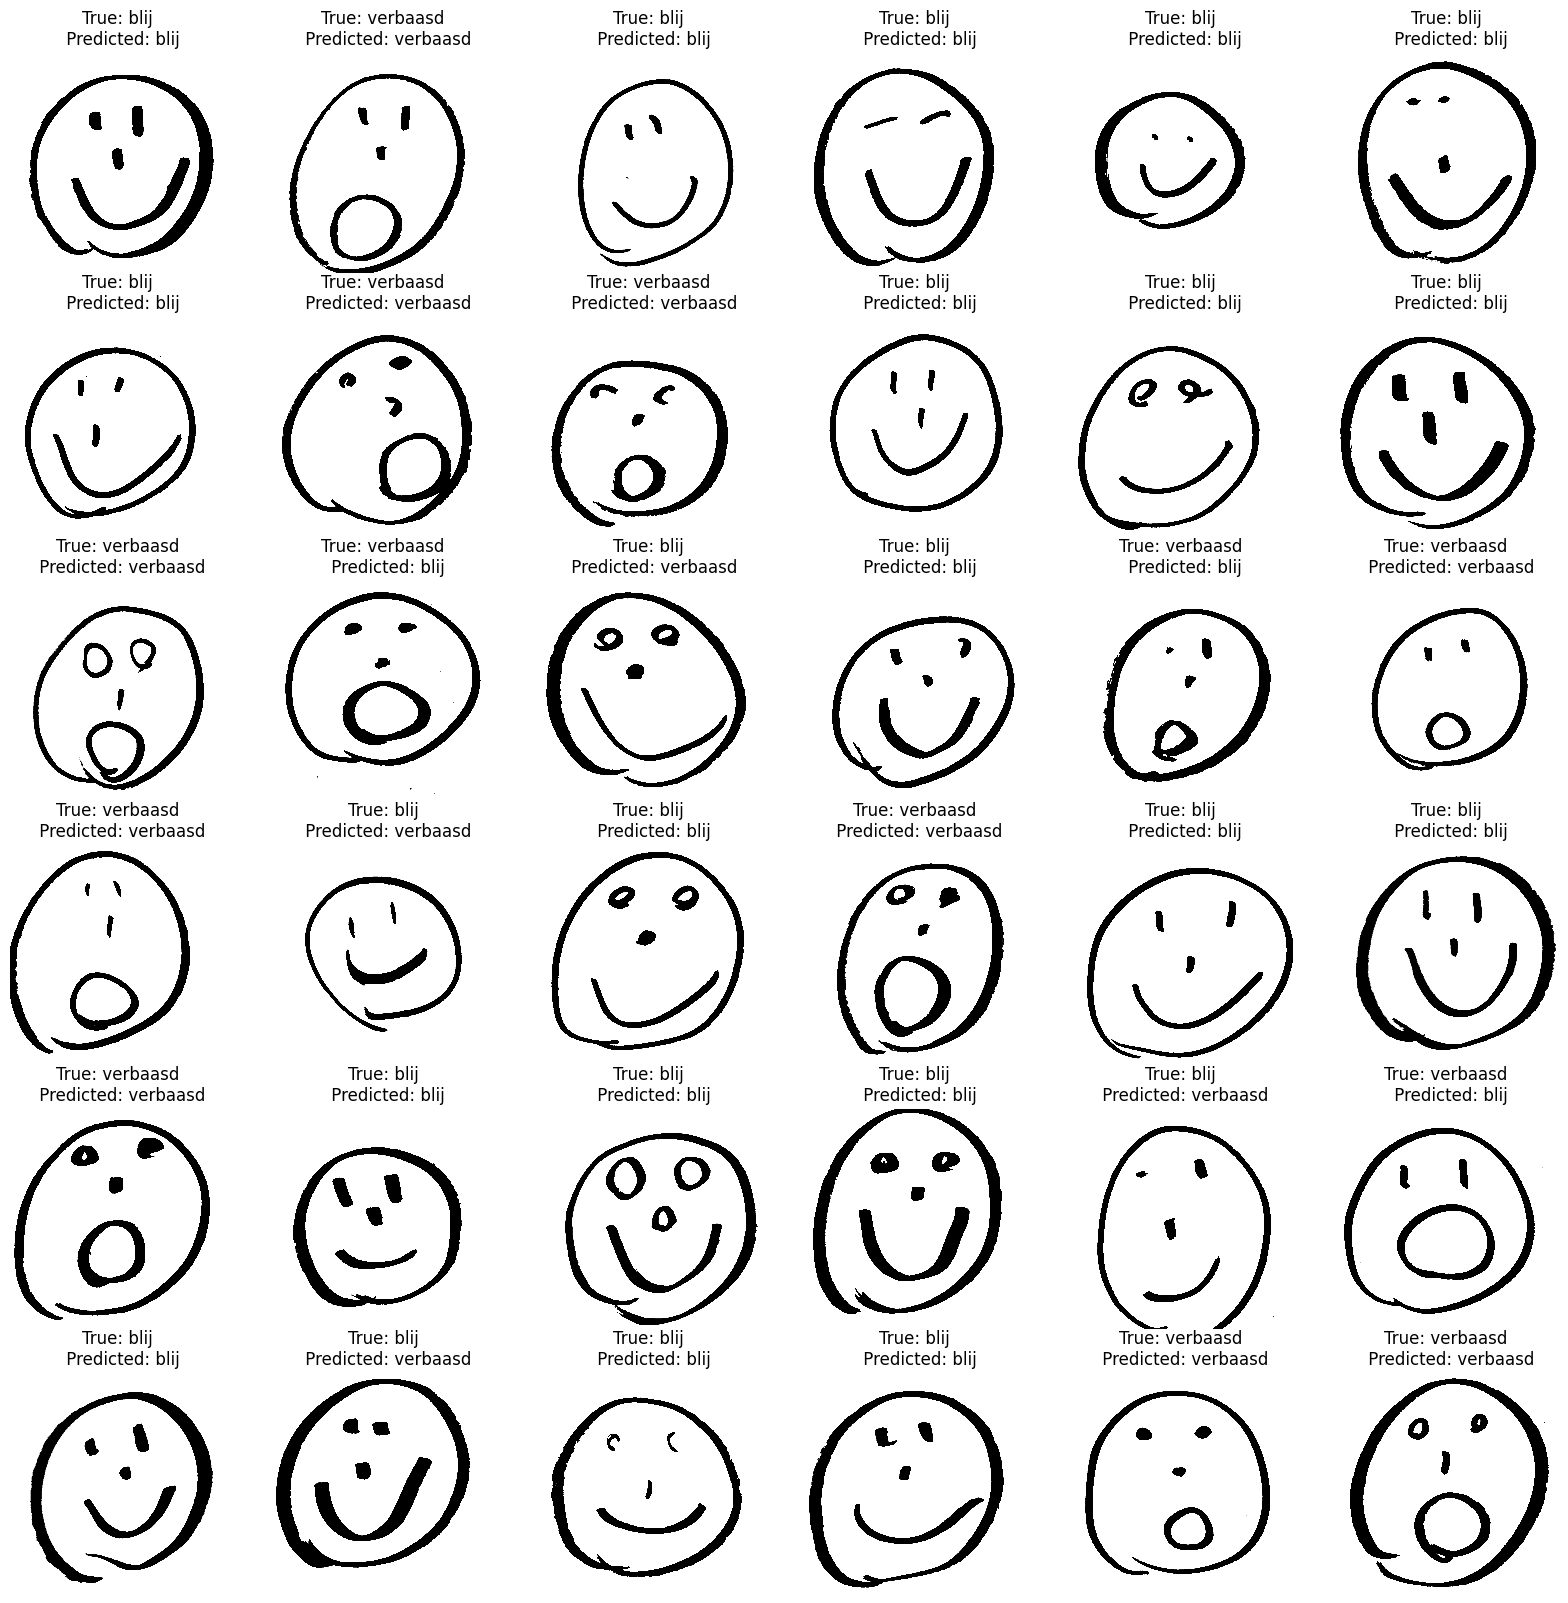

In [42]:
mapped_labels_true = ["blij" if label == 0 else "verbaasd" for label in labels_test]
mapped_labels_predicted = ["blij" if label < 0.5 else "verbaasd" for label in predictions]
mapped_labels_combined = [f"True: {mapped_labels_true[i]} \n Predicted: {mapped_labels_predicted[i]}" for i in range(len(mapped_labels_true))]
toon_afbeeldingen(afbeeldingen_test, mapped_labels_combined)

(3, 3, 1, 1)


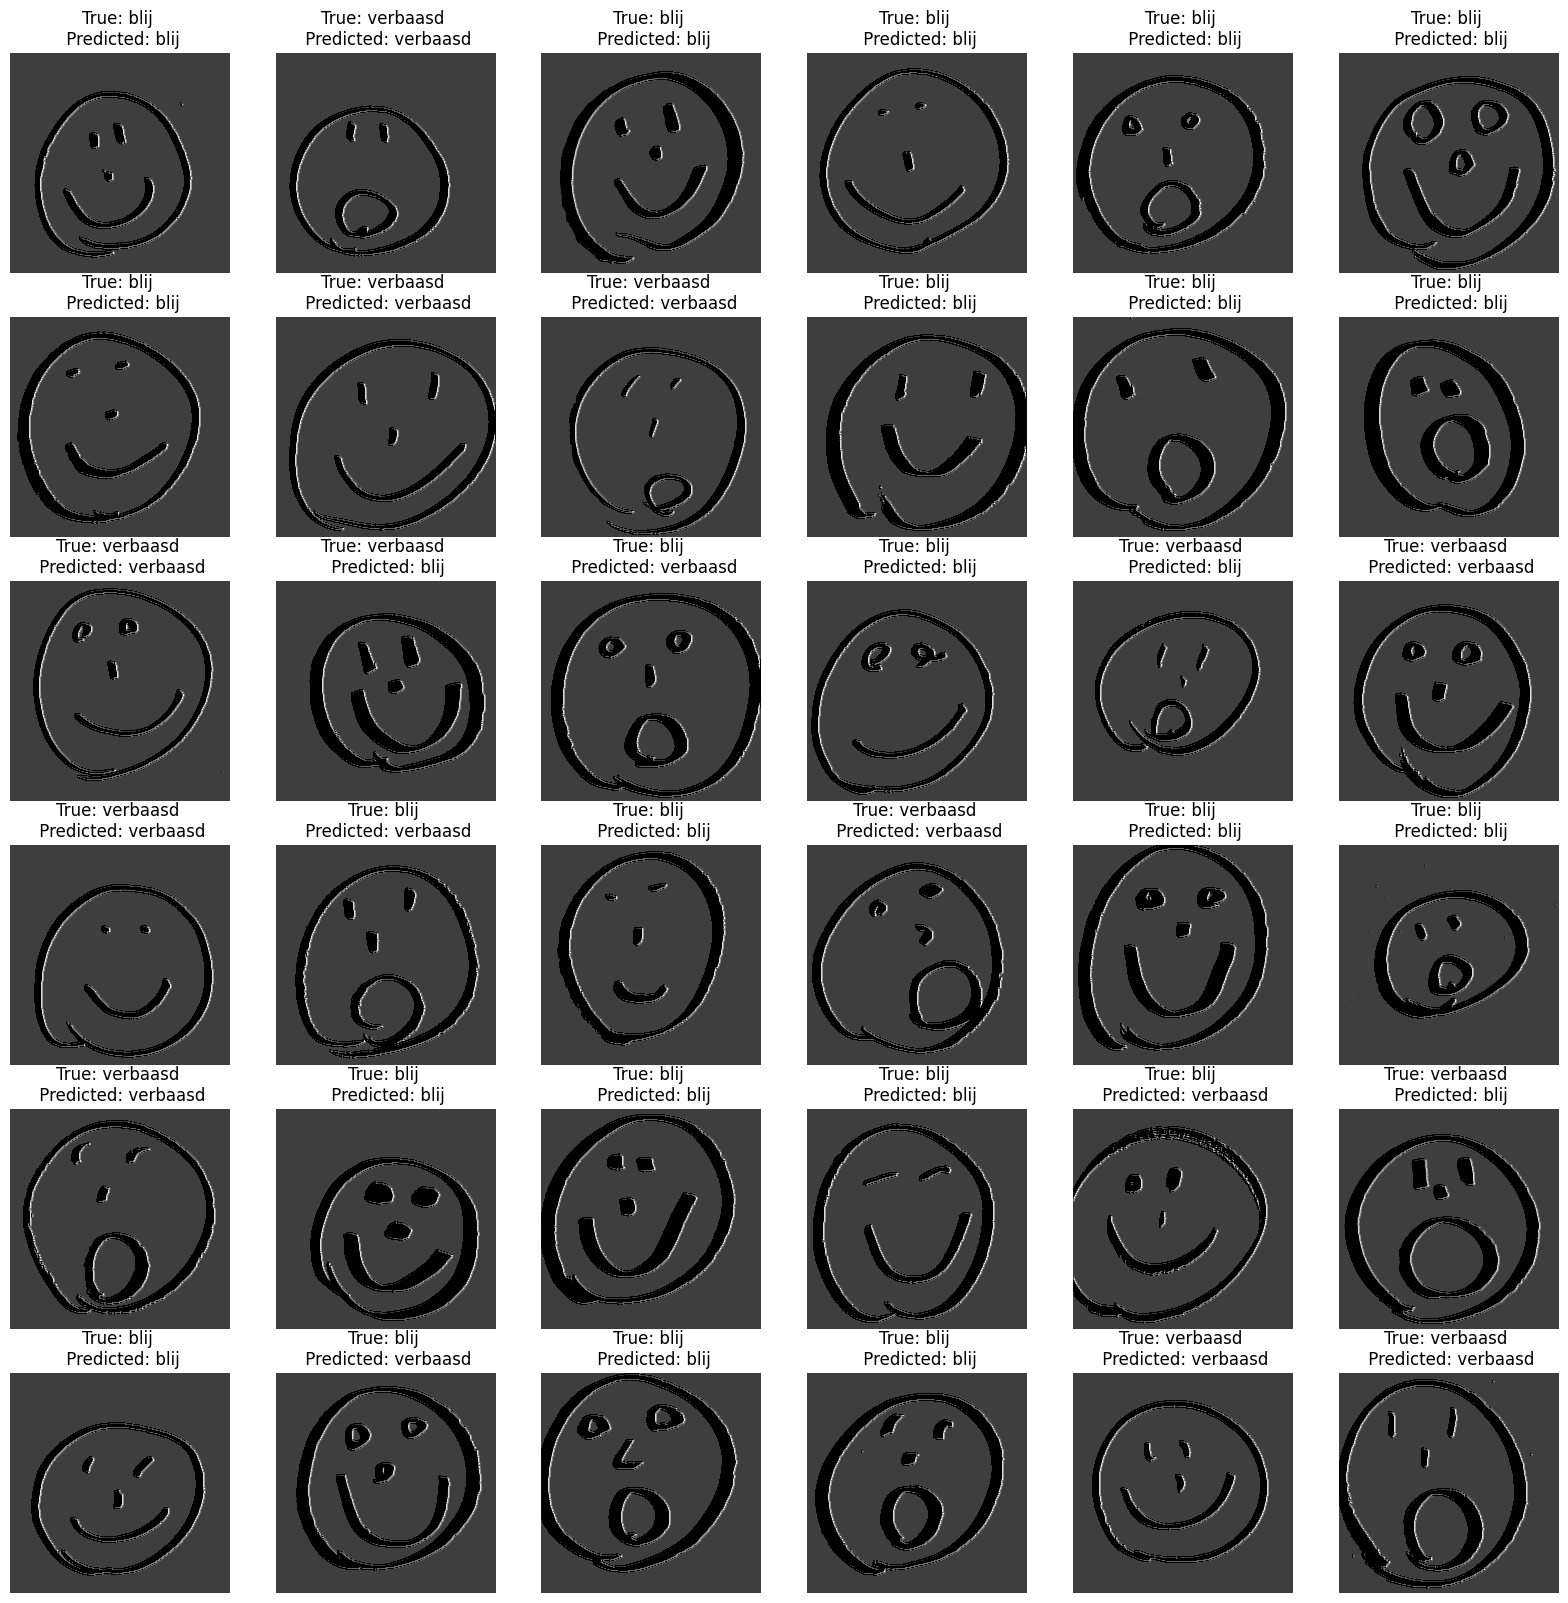

In [53]:
# Apply the filter from the first layer to the test images
def apply_filter(model, images, layer=0, filter=0):
    # Get the weights of the first layer
    weights = model.layers[layer].get_weights()[0]
    print(weights.shape)

    # Apply the filter to the images
    filtered_images = []
    for image in images:
        filtered_image = cv2.filter2D(image, -1, weights[:, :, 0, filter])
        filtered_images.append(filtered_image)

    return np.array(filtered_images)

# Apply the filter to the test images
filtered_images = apply_filter(model, afbeeldingen_test)

# Display the filtered images
toon_afbeeldingen(filtered_images, mapped_labels_combined)


(3, 3, 1, 2)


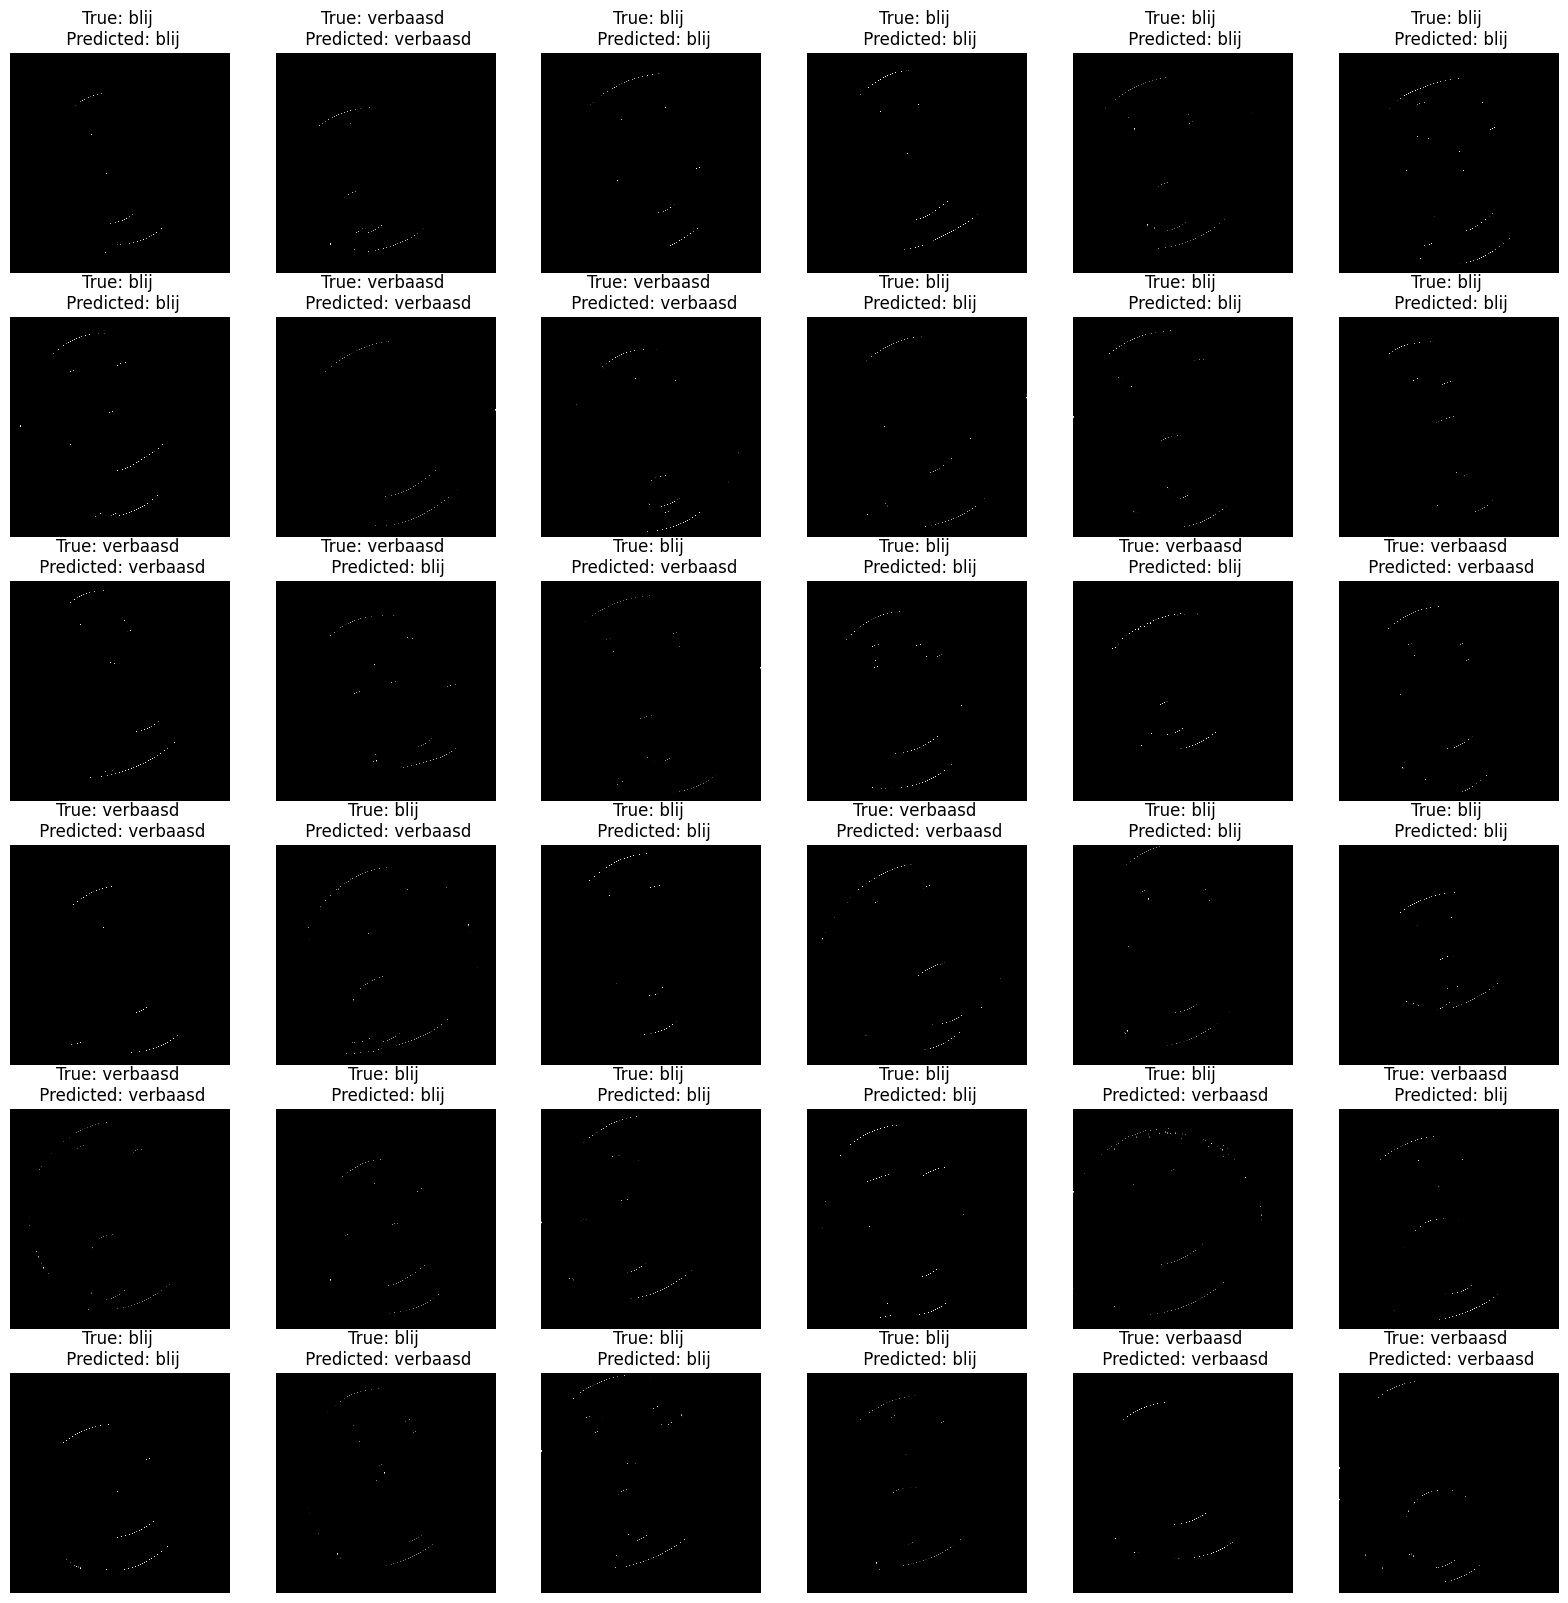

In [55]:
# Apply filter from the second layer to the test images
filtered_images = apply_filter(model, afbeeldingen_test, layer=3, filter=0)

# Display the filtered images
toon_afbeeldingen(filtered_images, mapped_labels_combined)

(3, 3, 2, 4)


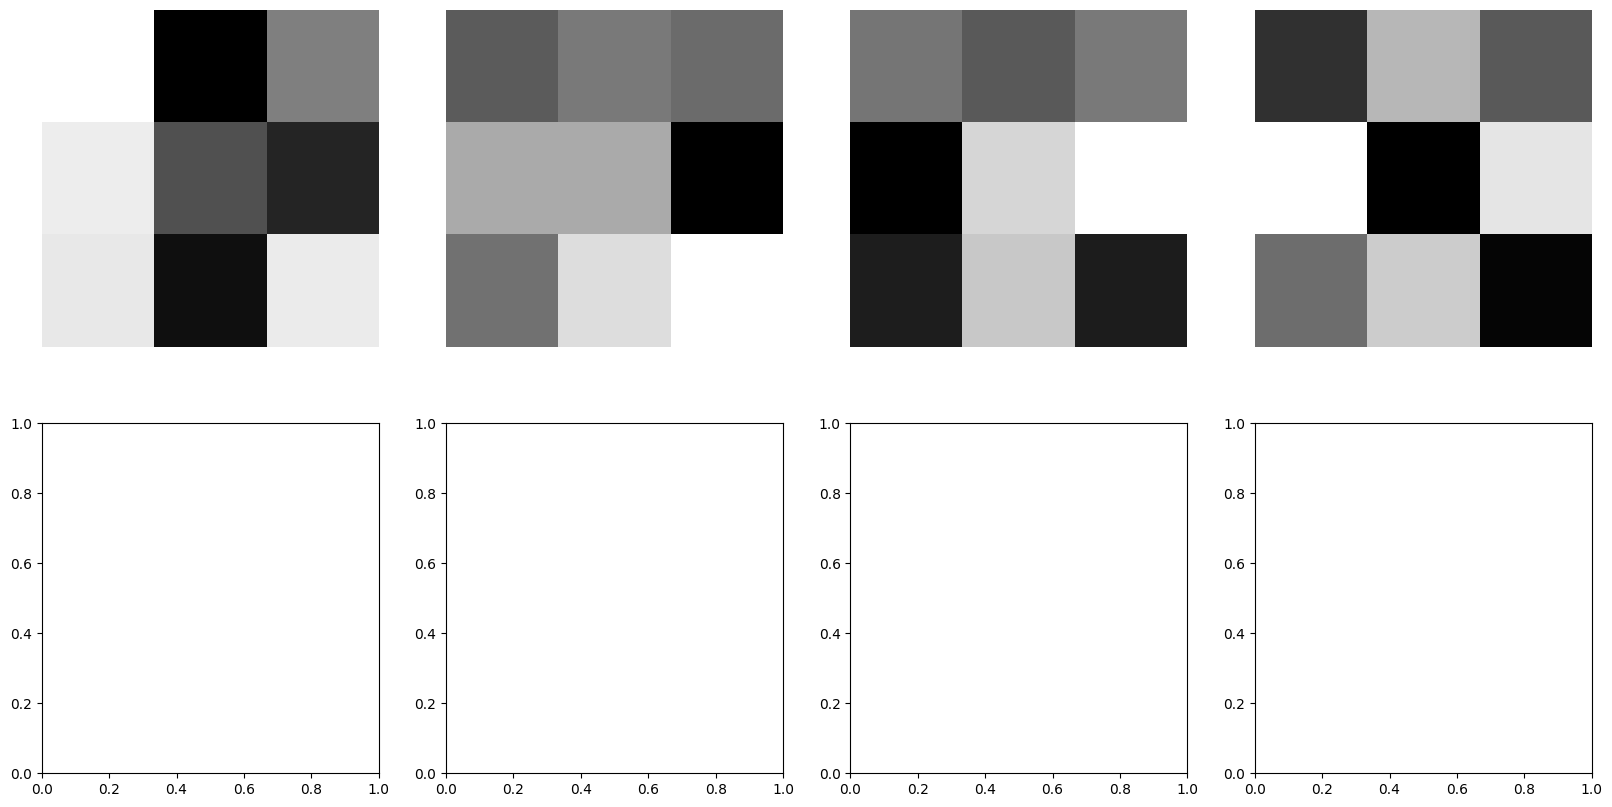

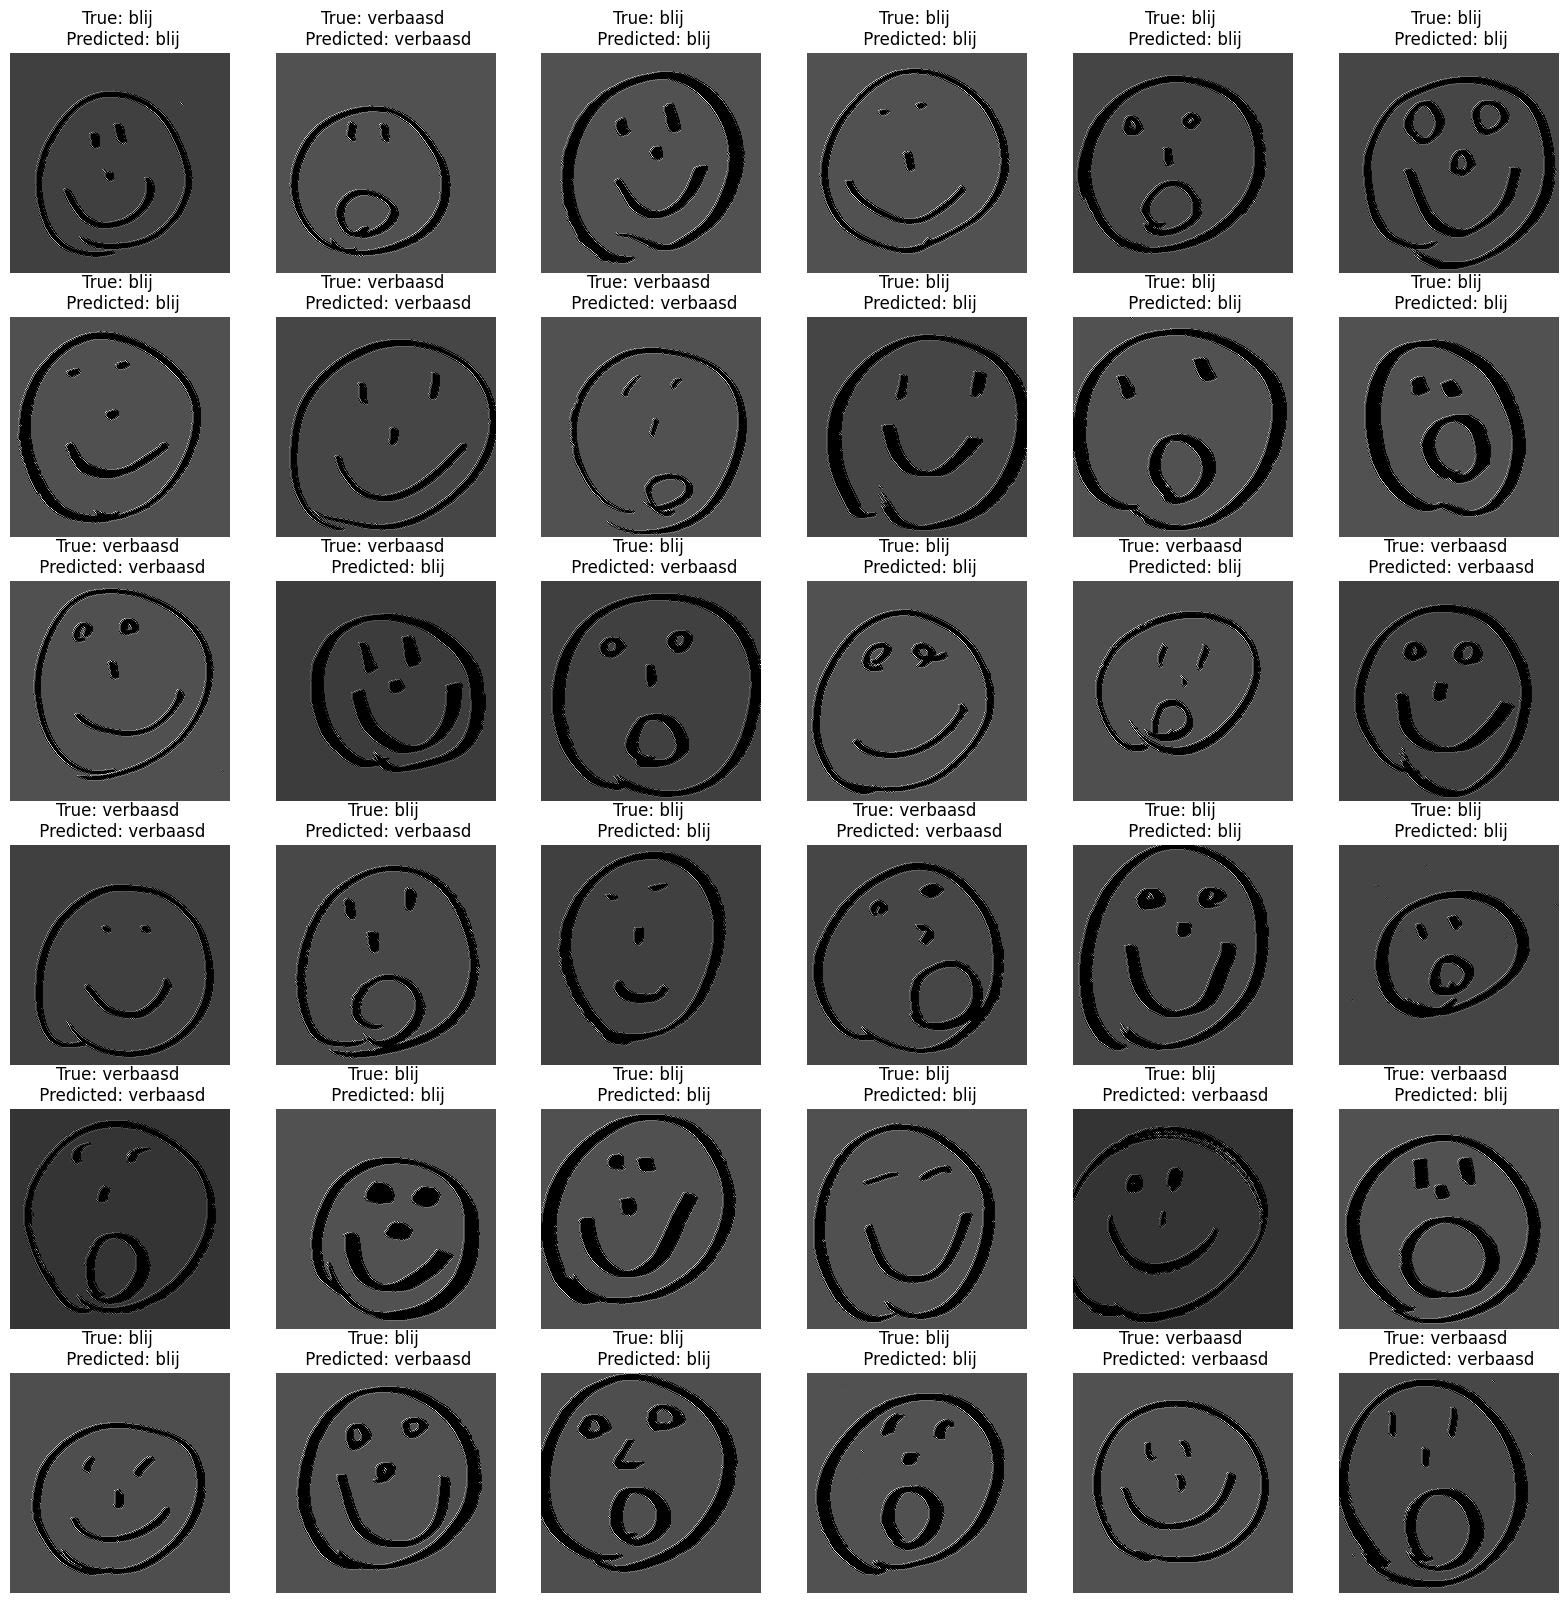

In [63]:
# Apply filter from the second layer to the test images
filtered_images = apply_filter(model, afbeeldingen_test, layer=6, filter=3)
inspect_filters(model, layer=5)

# Display the filtered images
toon_afbeeldingen(filtered_images, mapped_labels_combined)

(3, 3, 1, 1)
(3, 3, 1, 2)
(3, 3, 2, 4)
(3, 3, 4, 8)
(3, 3, 4, 8)


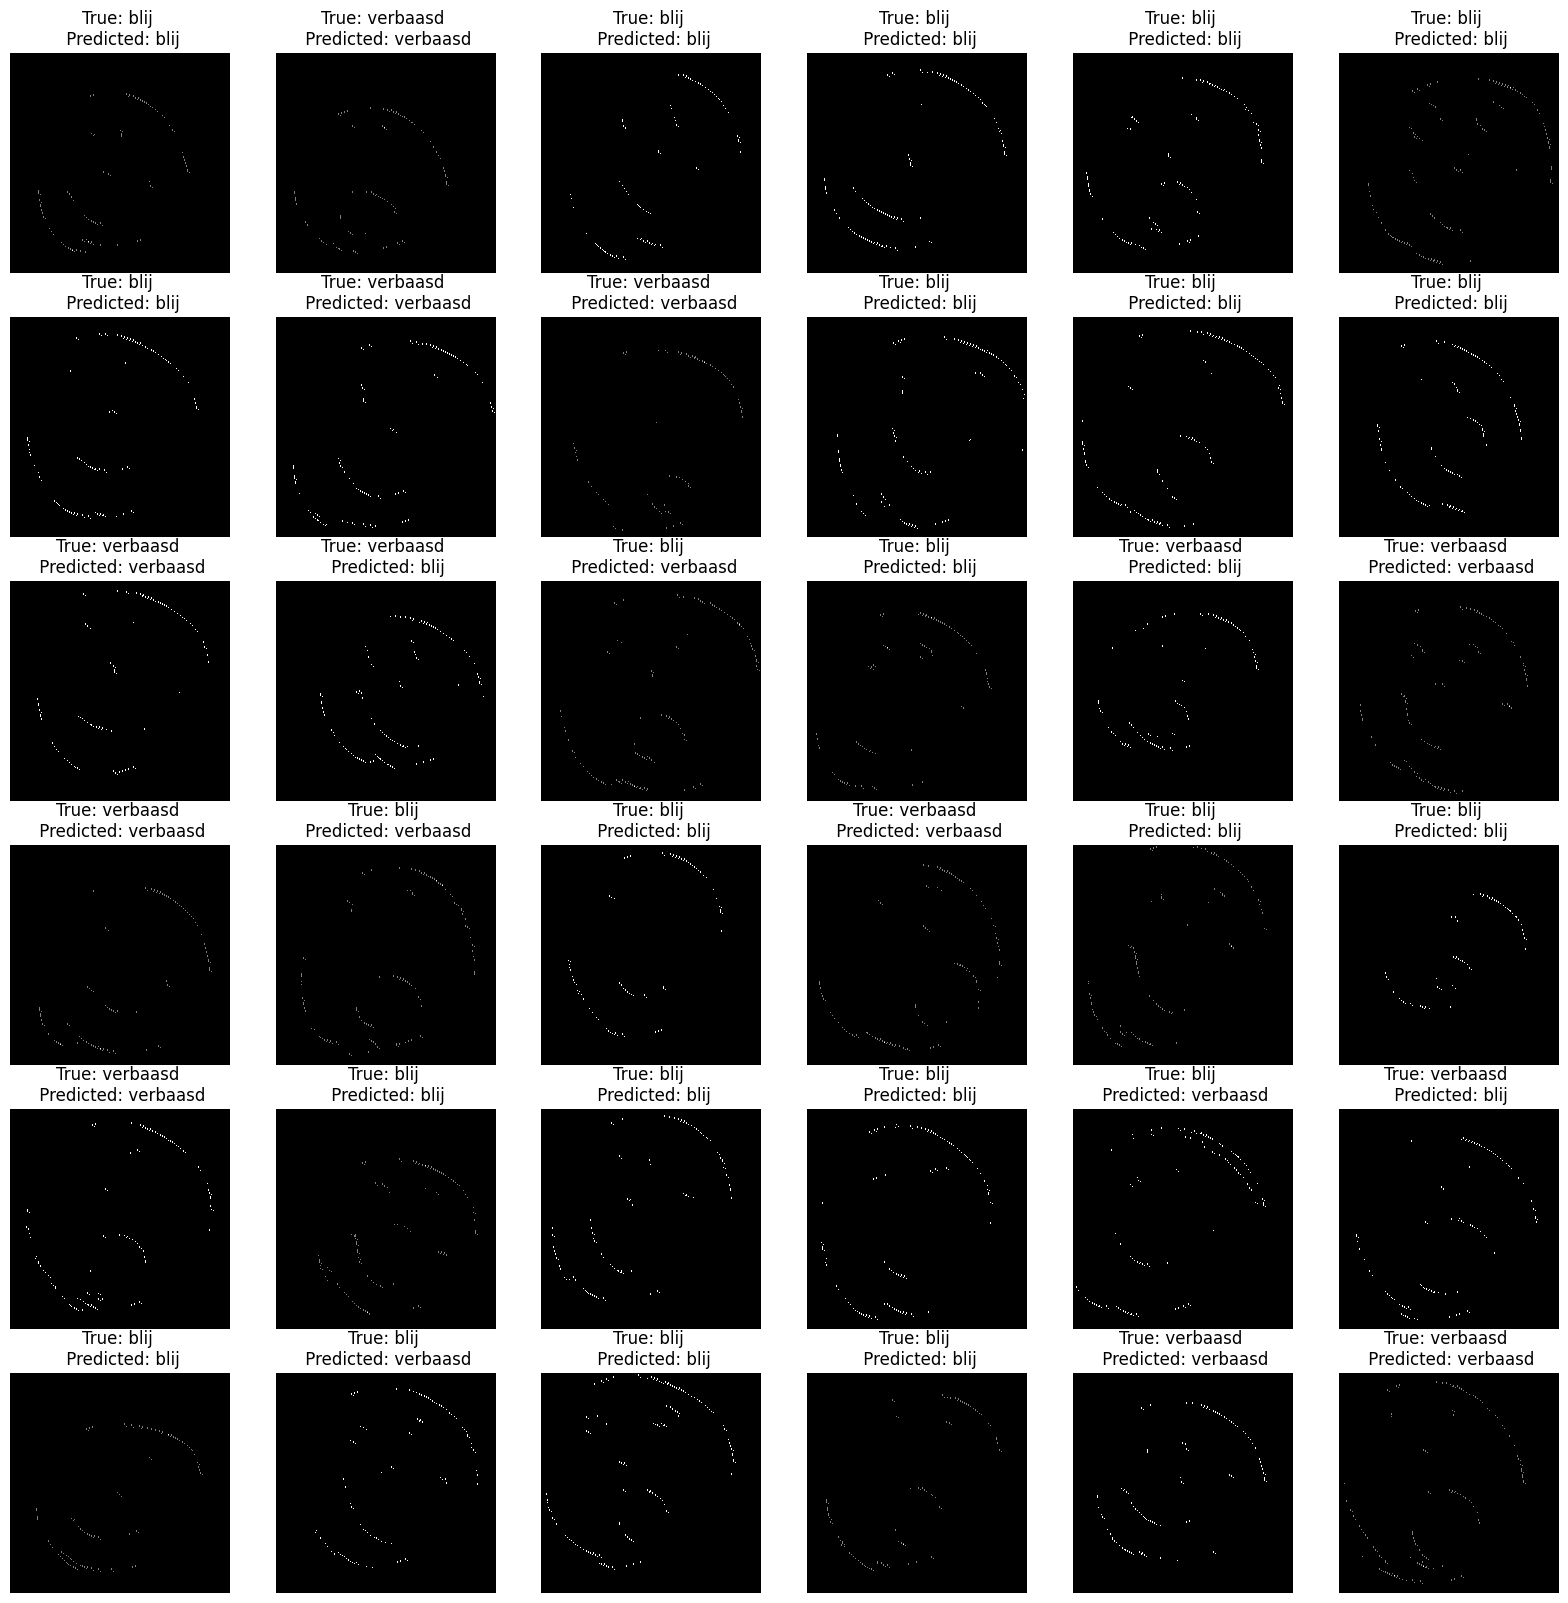

In [75]:
# Apply filter from the second layer to the test images
filtered_images1 = apply_filter(model, afbeeldingen_test)
filtered_images2 = apply_filter(model, filtered_images1, layer=3, filter=1)
filtered_images3 = apply_filter(model, filtered_images2, layer=6, filter=0)
filtered_images4 = apply_filter(model, filtered_images3, layer=9, filter=4)
filtered_images5 = apply_filter(model, filtered_images4, layer=9, filter=4)

# Display the filtered images
toon_afbeeldingen(filtered_images5, mapped_labels_combined)